In [1]:
# default_exp sine_model

In [2]:
#hide 
%load_ext autoreload
%autoreload 2

In [3]:
#export
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *

# Sine Model

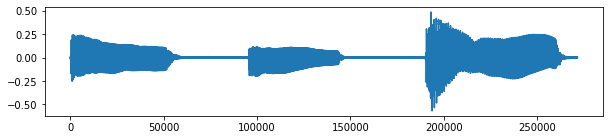

In [4]:
fn = "data/E_octaves_both.wav"
x, sr = load_audio(fn)
plot(x)

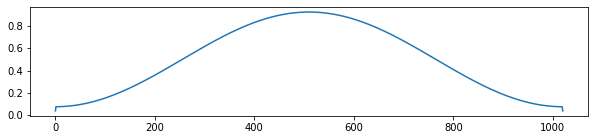

In [5]:
n_fft = 1024
h = 510
m = h*2 + 1
wn = 'hamming'
w = get_cola_window('hamming', m, h)
plot(w)

In [6]:
spectrum = list(stft(x, n_fft, h, w))
mx, px = (np.stack(s) for s in zip(*spectrum))
print(f'n_fft: {n_fft}, m: {m}, h: {h}, w: {wn}')
mx.shape, px.shape

n_fft: 1024, m: 1021, h: 510, w: hamming


((534, 513), (534, 513))

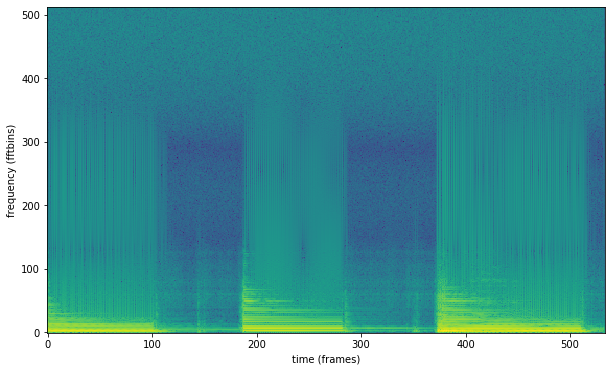

In [7]:
plot_mags(mx)

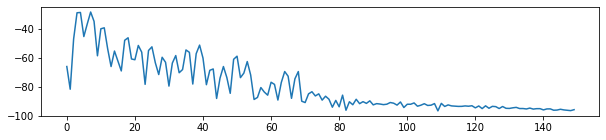

In [8]:
frame_i = 200
mags = mx[frame_i]
plot(mags[:150])

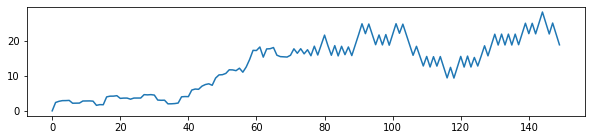

In [9]:
phases = px[frame_i]
plot(phases[:150])

## Peak Detection

In [10]:
#export
def detect_peaks(x: np.ndarray, thresh: float) -> np.ndarray:
    # first and last cannot be peaks
    above_thresh = np.greater(x[1:-1], thresh)
    gt_before = np.greater(x[1:-1], x[:-2])
    gt_after =  np.greater(x[1:-1], x[2:])
    is_peak = above_thresh & gt_before & gt_after
    peaks_i = is_peak.nonzero()[0] + 1
    return peaks_i 

In [11]:
arr = np.array([2, 10, 3, 8, -2, 3, 1, 9, 0, 2, 1])
assert np.array_equal(detect_peaks(arr, 1), [1,3,5,7,9])
assert np.array_equal(detect_peaks(arr, 2), [1,3,5,7])
assert np.array_equal(detect_peaks(arr, 3), [1,3,7])

In [12]:
#export
def plot_peaks(x, peak_i, t=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x)
    plt.plot(peak_i, x[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

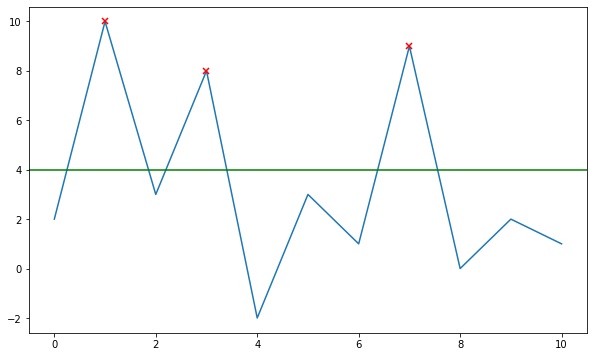

In [13]:
t = 4
plot_peaks(arr, detect_peaks(arr, t), t)

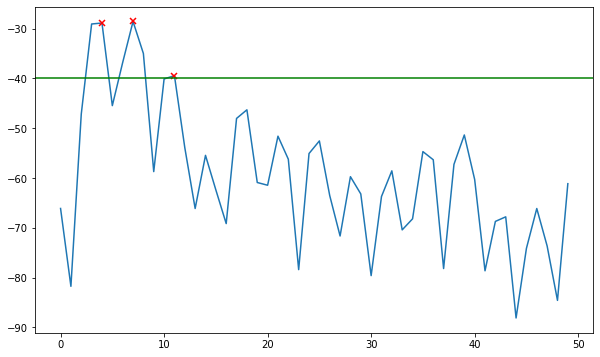

In [14]:
t = -40
peak_i = detect_peaks(mags, t)[:10]
plot_peaks(mags[:50], peak_i, t)

## Peak Interpolation

In [15]:
#export
def interpolate_peaks(mags, peak_i):
    a, b, c = mags[peak_i-1], mags[peak_i], mags[peak_i+1]
    ipeak_i = peak_i + 0.5 * (a - c) / (a - 2*b + c)
    ipeak_mags = b - 0.25 * (a - c) * (ipeak_i - peak_i)
    return ipeak_i, ipeak_mags

In [16]:
#export
def plot_ipeaks(mags, ipeak_i, ipeak_mag, peak_i=None, t=None):
    plt.figure(figsize=(10, 6))
    plt.plot(mags)
    plt.plot(ipeak_i, ipeak_mag, marker='x', color='g', linestyle='', markeredgewidth=1.5)
    if peak_i is not None:
        plt.plot(peak_i, mags[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

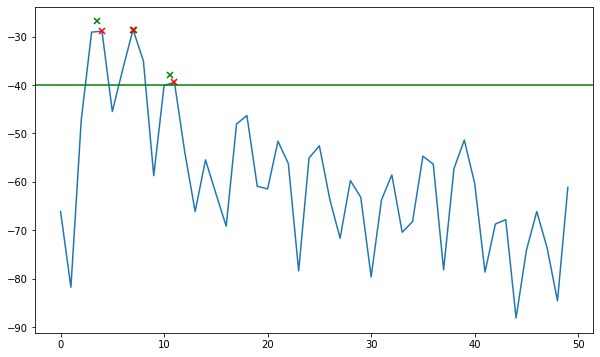

In [17]:
ipeak_i, ipeak_mag = interpolate_peaks(mags, peak_i)
plot_ipeaks(mags[:50], ipeak_i, ipeak_mag, peak_i=peak_i, t=t)

In [18]:
ipeak_freq = sr * ipeak_i / n_fft
ipeak_freq

array([164.6136, 331.0182, 494.2583])

In [19]:
idx = np.arange(phases.size)
ipeak_phase = np.interp(ipeak_i, idx, phases)
ipeak_phase

array([2.9288, 2.1999, 2.8359])

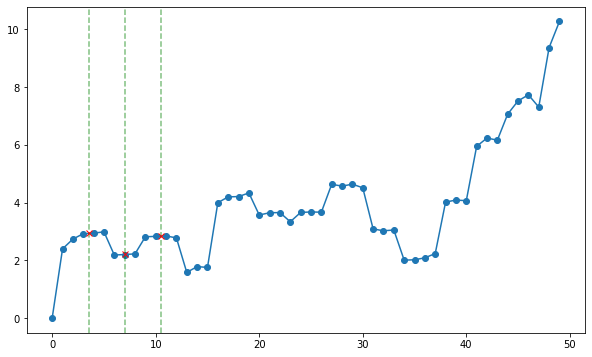

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(idx[:50], phases[:50], marker='o')
for i in ipeak_i:
    plt.axvline(i, c='g', linestyle='--', alpha=0.5)
plt.plot(ipeak_i, ipeak_phase, c='r', linestyle='', marker='x')

## Synthesis

In [21]:
def sinc(x, N):
    y = np.sin(N * x/2) / np.sin(x/2)                  # compute the sinc function
    y[np.isnan(y)] = N                                 # avoid NaN if x == 0
    return y

def genBhLobe(x, N=512):
    f = x*np.pi*2/N                                         # frequency sampling
    df = 2*np.pi/N
    y = np.zeros(x.size)                                    # initialize window
    consts = [0.35875, 0.48829, 0.14128, 0.01168]           # window constants
    for m in range(0,4):                                    # iterate over the four sincs to sum
        y += consts[m]/2 * (sinc(f-df*m, N) + sinc(f+df*m, N))  # sum of scaled sinc functions
    y = y/N/consts[0]                                       # normalize
    return y

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


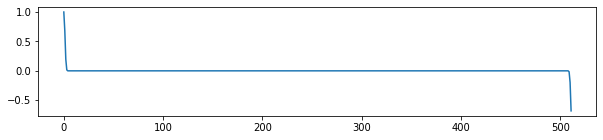

In [22]:
a = np.arange(512)
plot(genBhLobe(a))

In [23]:
def generate_sine_spectrum(ipeak_f, ipeak_m, ipeak_p, N, fs):
    Y = np.zeros(N, dtype=np.complex64)
    hN = N//2
    
    ipeak_i = ipeak_f * N / fs
    assert (ipeak_i > 0).all()  # not sure 
    assert (ipeak_i <= hN).all(), f'{ipeak_i.max(), hN}'
    
    for i, mag, phase in zip(ipeak_i, ipeak_m, ipeak_p):
        bin_remainder = round(i) - i
        lb = np.arange(bin_remainder-4, bin_remainder+5)
        lmag = genBhLobe(lb) * 10**(mag/20)
        bs = np.arange(round(i) - 4, round(i) + 5, dtype=int)        
        for m, b in enumerate(bs):
            if b < 0:      # lobe crosses DC
                Y[-b] += lmag[m]*np.exp(-1j*phase)
            
            elif b > hN:   # lobe crosses nyquist
                Y[b] += lmag[m] * np.exp(-1j*phase)
            
            elif b == 0 or b == hN:   #limits of spectrum
                Y[b] += lmag[m]*np.exp(1j*phase) + lmag[m]*np.exp(-1j*phase)
            
            else:  # pos freq range
                Y[b] += lmag[m]*np.exp(1j*phase)
            
        Y[hN+1:] = Y[hN-1:0:-1].conjugate()
    return Y
            

Y = generate_sine_spectrum(ipeak_freq, ipeak_mag, ipeak_phase, n_fft, sr)

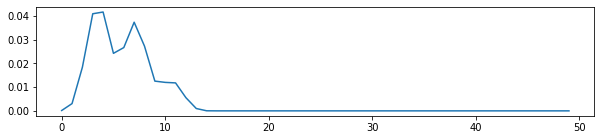

In [24]:
plot(abs(Y)[:50])

### blackman window..

In [25]:
bh = genBhLobe(np.arange(6))
bh[:6]

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([ 1.0000e+00,  6.8054e-01,  1.9691e-01,  1.6279e-02, -6.5010e-21,
        6.5013e-21])

In [26]:
m = 512
bh = get_window('blackmanharris', m)
bh /= bh.sum()
bhm, bhp = fft_analysis(bh, m)
bhm[:6]

array([   0.    ,   -3.3429,  -14.1148,  -35.7676, -313.0712, -313.0712])

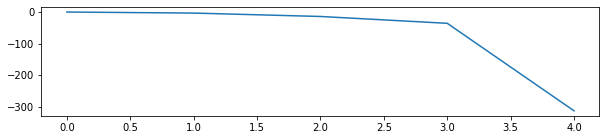

In [27]:
plot(bhm[:5])

## sineModel

In [28]:
x, sr = load_audio(fn)
n_fft = 2048
m = 1001
h = 512
t = -80
w = get_cola_window('hamming', n_fft, h)

In [29]:
w.sum()

512.0

In [30]:
from scipy.signal import blackmanharris, triang

In [31]:
#export
def synth_window(n_fft: int) -> np.ndarray:
    h = n_fft // 4
    t_win = triang(2 * h)
    t_win = np.pad(t_win, (h, h), mode='constant')
    bh_win = blackmanharris(n_fft)
    bh_win /= bh_win.sum()
    win = t_win / bh_win
    return win

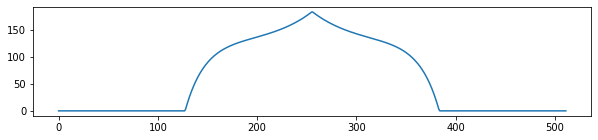

In [32]:
sw = synth_window(512)
plot(sw)

In [33]:
sw.sum()

31544.949755809088

In [34]:
def sine_model(x, fs, w, n_fft, t):
    n_fft_synth = 512
    h = n_fft_synth // 4
    
    sw = synth_window(n_fft_synth)

    frames = []
    for mx, px in stft(x, n_fft, h, w):        
        peak_i = detect_peaks(mx, t)
        ipeak_i, ipeak_m = interpolate_peaks(mx, peak_i)
        ipeak_p = np.interp(ipeak_i, np.arange(px.size), px)
        ipeak_f = fs * ipeak_i / n_fft
        
        Y = generate_sine_spectrum(ipeak_f, ipeak_m, ipeak_p, n_fft_synth, fs)
        fft_buffer = np.real(np.fft.ifft(Y))
        yw = zero_phase_buffer(fft_buffer, n_window=n_fft_synth, reverse=True)        
        frames.append(sw*yw)
        
    return synth_frames(frames, h, x.size)

In [35]:
x.shape, w.shape, n_fft, t, sr

((271522,), (2048,), 2048, -80, 48000)

In [36]:
w.sum()

512.0

In [37]:
%%time

y = sine_model(x, sr, w, n_fft, t)

CPU times: user 9.25 s, sys: 11.6 ms, total: 9.26 s
Wall time: 9.26 s


In [38]:
# 4.35s to generate a 5.66s sound

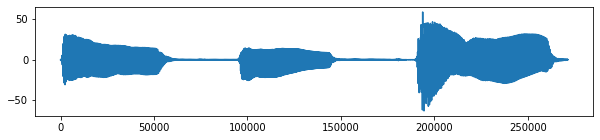

In [39]:
plot(y)

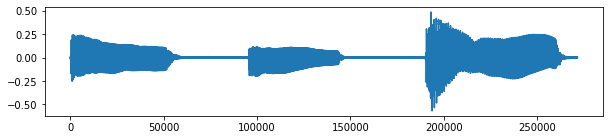

In [40]:
plot(x)

In [41]:
import IPython.display as ipd

In [42]:
ipd.display(ipd.Audio(x, rate=sr))

In [43]:
ipd.display(ipd.Audio(y, rate=sr))

## Sine Model Analysis

In [44]:
#export
class Frame:
    def __init__(self, freqs=None, mags=None, phases=None):
        self.freqs = freqs
        self.mags = mags
        self.phases = phases
    
    def __len__(self):
        return self.freqs.size

In [45]:
#export
def sine_model_analysis(x, fs, w, n_fft, h, t):
    frames = []
    for frame_i, (mx, px) in enumerate(stft(x, n_fft, h, w)):
        peak_i = detect_peaks(mx, t)
        ipeak_i, ipeak_m = interpolate_peaks(mx, peak_i)
        ipeak_p = np.interp(ipeak_i, np.arange(px.size), px)
        ipeak_f = fs * ipeak_i / n_fft

        frame = Frame(ipeak_f, ipeak_m, ipeak_p)
        frames.append(frame)
        
    return frames

In [46]:
%%time

frames = sine_model_analysis(x, sr, w, n_fft, h, t)
len(frames)

CPU times: user 203 ms, sys: 0 ns, total: 203 ms
Wall time: 202 ms


534

In [47]:
#export
def synth_window(n_fft: int, h: int) -> np.ndarray:
    t_win = triang(2 * h)
    padding = (n_fft - 2*h) // 2
    t_win = np.pad(t_win, (padding, padding), mode='constant')
    bh_win = blackmanharris(n_fft)
    bh_win /= bh_win.sum()
    win = t_win / bh_win
    return win

In [48]:
#export
def sine_model_synthesis(frames, n_fft, h, fs):
    n_frames = len(frames)
    y_length = h*(n_frames - 1) + n_fft
    y = np.zeros(y_length)
    
    synth_win = synth_window(n_fft, h)    

    for i, f in enumerate(frames):        
        Y = generate_sine_spectrum(f.freqs, f.mags, f.phases, n_fft, fs)        
        fft_buffer = np.real(np.fft.ifft(Y))
        yw = zero_phase_buffer(fft_buffer, n_window=n_fft, reverse=True)   
        offset = i*h
        y[offset:offset+n_fft] += synth_win * yw
        
    return y
        

In [49]:
%%time

sr1 = sr
y = sine_model_synthesis(frames, 4096, 512, sr1)

y = y[2048-512:]
y = y[:x.size]
y.max()

CPU times: user 2.15 s, sys: 49 µs, total: 2.15 s
Wall time: 2.15 s


0.46131845335994776

In [50]:
ipd.display(ipd.Audio(y, rate=sr1))
y.shape

(271522,)

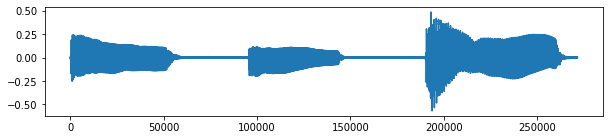

In [51]:
plot(x)

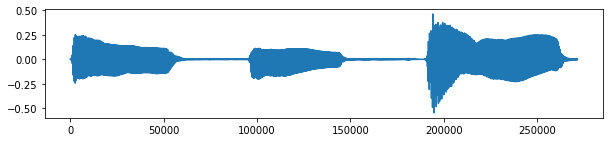

In [52]:
plot(y)

## All together

In [53]:
x, sr = load_audio(fn)
n_fft = 4096
m = 2047
h = 512
t = -80
w = get_cola_window('blackman', n_fft, h)
frames = sine_model_analysis(x, sr, w, n_fft, h, t)
len(frames)

538

In [54]:
y = sine_model_synthesis(frames, 2048, 512, sr1)

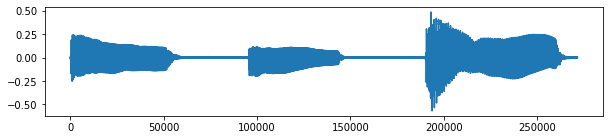

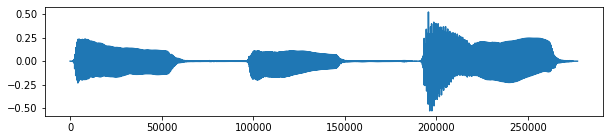

In [55]:
plot(x)
plot(y)

### sine_tracking

In [56]:
[len(f) for f in frames[:10]]

[0, 5, 20, 28, 37, 43, 41, 32, 30, 27]

In [57]:
np.set_printoptions(precision=2)

In [58]:
[f.freqs[:5] for f in frames[:10]]

[array([], dtype=float64),
 array([165.88, 275.81, 512.28, 659.65, 798.3 ]),
 array([162.23, 256.2 , 324.4 , 500.27, 578.63]),
 array([ 94.55, 162.59, 251.12, 333.04, 402.81]),
 array([ 85.41, 163.55, 248.59, 333.24, 411.3 ]),
 array([ 83.09, 164.4 , 246.74, 332.18, 413.47]),
 array([ 82.51, 164.92, 245.54, 330.36, 413.09]),
 array([ 82.57, 165.07, 245.24, 329.27, 411.29]),
 array([ 82.56, 165.13, 245.56, 329.19, 410.7 ]),
 array([ 82.4 , 165.19, 245.95, 329.15, 410.72])]

In [59]:
# tfreq, tmag, tphase = sineTracking(ipfreq, ipmag, ipphase, tfreq, freqDevOffset, freqDevSlope)

In [60]:
max_n_sines = 100
min_sine_dur = 0.01


In [61]:
#export

def sine_tracking(frame: Frame, 
                  tfreq,
                  freq_dev_offset=20, 
                  freq_dev_slope=0.01):
    #print('--------') 
    
    tfreq_out = np.zeros(tfreq.size)
    tmag_out = np.zeros(tfreq.size)
    tphase_out = np.zeros(tfreq.size)
    
    cur_i = np.arange(frame.freqs.size)
    prev_i = np.arange(tfreq.size)  # incomingTracks
    new_i = np.zeros(tfreq.size, dtype=np.int) - 1
    mag_order = np.argsort(-frame.mags)
    
    tmp_freq = np.copy(frame.freqs)
    tmp_mag = np.copy(frame.mags)
    tmp_phase = np.copy(frame.phases)
    
    #print("tfreq", tfreq, ' tmp_freq', tmp_freq)
    
    
    # continue tracks

    if prev_i.size > 0:
        for i in mag_order:
            if prev_i.size == 0: break
                
            track = np.argmin(abs(tmp_freq[i] - tfreq[prev_i]))
            freq_dist = abs(tmp_freq[i] - tfreq[prev_i[track]])
            #print(f'  i: {i}, track: {track}, dist: {freq_dist}')
            thresh = (freq_dev_offset + freq_dev_slope * tmp_freq[i])
            if freq_dist < thresh:
                new_i[prev_i[track]] = i
                prev_i = np.delete(prev_i, track)
    
    #print('new_i', new_i)
    index_t = np.array(np.nonzero(new_i != -1), dtype=np.int)[0]  # empty for now
    #print('index_t', index_t)
    if index_t.size > 0:
        index_p = new_i[index_t]
        tfreq_out[index_t] = tmp_freq[index_p]
        tmag_out[index_t] = tmp_mag[index_p]
        tphase_out[index_t] = tmp_phase[index_p]
        
        tmp_freq = np.delete(tmp_freq, index_p)
        tmp_mag = np.delete(tmp_mag, index_p)
        tmp_phase = np.delete(tmp_phase, index_p)
    
    #print(tfreq)
    empty_t = np.array(np.nonzero(tfreq == 0), dtype=np.int)[0] # indexes of empty incoming tracks
    #print(empty_t)
    n_empty = empty_t.size

    peaks_left = np.argsort(-tmp_mag)
    #print(f'peaks_left: {peaks_left.size}, n_empty: {n_empty}')

    
    # create new tracks
    
    if ((peaks_left.size > 0) & (n_empty >= peaks_left.size)): 
        pass
    elif ((peaks_left.size > 0) & (n_empty < peaks_left.size)):
        idx = peaks_left[:empty_t.size]        
        tfreq_out[empty_t]  = tmp_freq[idx]
        tmag_out [empty_t]  = tmp_mag[idx]
        tphase_out[empty_t] = tmp_phase[idx]

        idx = peaks_left[empty_t.size:]
        tfreq_out  = np.append(tfreq_out,  tmp_freq[idx])
        tmag_out   = np.append(tmag_out,   tmp_mag[idx])
        tphase_out = np.append(tphase_out, tmp_phase[idx])
        
    return Frame(tfreq_out, tmag_out, tphase_out)

In [62]:
def process_frames(frames, 
                   max_n_sines = 1000,
                   min_sine_dur = 0.01, 
                   freq_dev_offset=20,
                   freq_dev_slope=0.01):
    tfreq = np.array([])
    out_frames = []
    for frame in frames:
        out_frame = sine_tracking(frame, tfreq, freq_dev_offset=freq_dev_offset, freq_dev_slope=freq_dev_slope);
        tfreq = out_frame.freqs
        out_frames.append(out_frame)
    return out_frames

(538, 96)


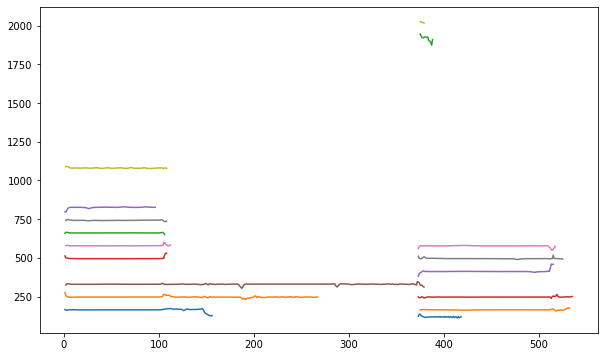

In [63]:
sine_frames = process_frames(frames)
max_frames = max(len(f) for f in sine_frames)
padded = [np.pad(f.freqs, (0, max_frames-f.freqs.size), 'constant') for f in sine_frames]
p = np.stack(padded)
p[p<=0] = np.nan

plt.figure(figsize=(10, 6))
for i in range(9):
    plt.plot(p[:, i])
    
print(p.shape)

In [64]:
sizes = np.array([f.freqs.size for f in frames])
sizes.min(), sizes.max(), sizes.mean(), sizes.std()

(0, 87, 15.239776951672862, 12.86360162592103)

(538, 96)


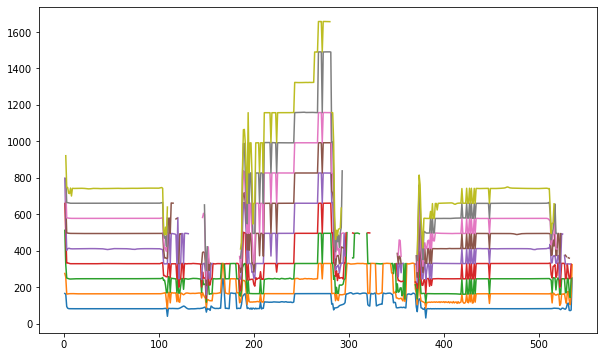

In [65]:
sine_frames = process_frames(frames)
max_frames = max(len(f) for f in sine_frames)
padded = [np.pad(f.freqs, (0, max_frames-f.freqs.size), 'constant') for f in frames]
p = np.stack(padded)
p[p<=0] = np.nan

plt.figure(figsize=(10, 6))
for i in range(9):
    plt.plot(p[:, i])
    
print(p.shape)

116

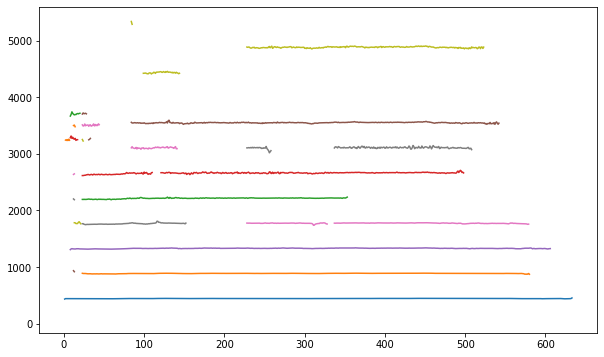

In [66]:
fn = '../../sms-tools/sounds/flute-A4.wav'
x, sr = load_audio(fn)
n_fft = 1024
m = 601
h = 150
t = -80
w = get_cola_window('blackman', m, h)

frames = sine_model_analysis(x, sr, w, n_fft, h, t)

min_sine_dur = 0.1
max_n_sines = 150
freq_dev_offset = 10
freq_dev_slope = 0.01

sine_frames = process_frames(frames,
                             max_n_sines=max_n_sines,
                             min_sine_dur=min_sine_dur, 
                             freq_dev_offset=freq_dev_offset,
                             freq_dev_slope=freq_dev_slope)
    
max_frames = max(len(f) for f in sine_frames)
padded = [np.pad(f.freqs, (0, max_frames-f.freqs.size), 'constant') for f in sine_frames]
p = np.stack(padded)
p[p<=0] = np.nan

plt.figure(figsize=(10, 6))
for i in range(9):
    plt.plot(p[:, i])
    
maxplotfreq = 5000.0
maxplotbin = int(n_fft*maxplotfreq/sr)
maxplotbin

n_fft: 1024, m: 601, h: 150, w: hamming


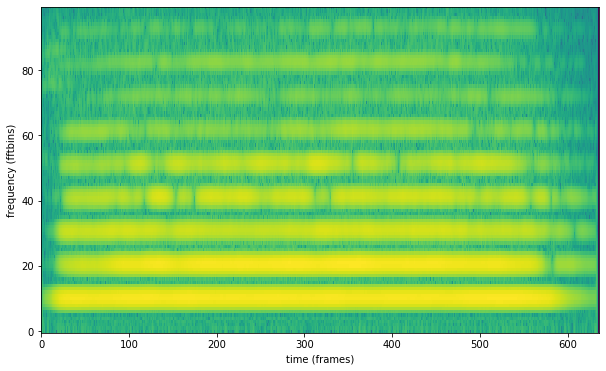

In [67]:
spectrum = list(stft(x, n_fft, h, w))
mx, px = (np.stack(s) for s in zip(*spectrum))
print(f'n_fft: {n_fft}, m: {m}, h: {h}, w: {wn}')
mx.shape, px.shape
plot_mags(mx[:,:100])

### Just show peaks

In [68]:
fn = '../../sms-tools/sounds/flute-A4.wav'
x, sr = load_audio(fn)
n_fft = 1024
m = 601
h = 150
t = -80
w = get_cola_window('blackman', m, h)

In [69]:
spectrum = list(stft(x, n_fft, h, w))
mx, px = (np.stack(s) for s in zip(*spectrum))

In [70]:
maxplotfreq = 5000.0
maxplotbin = int(n_fft*maxplotfreq/sr)

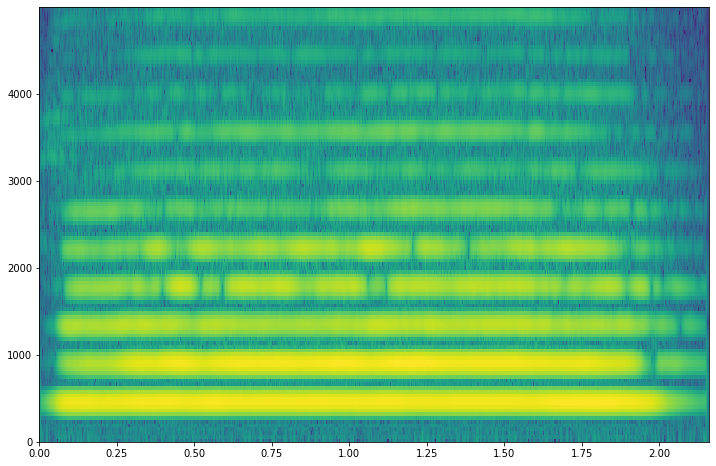

In [71]:
n_frames = mx[:,0].size
frame_time = h*np.arange(n_frames)/sr                             
bin_freq = np.arange(maxplotbin+1)*sr/n_fft

plt.figure(figsize=(12, 8))
plt.pcolormesh(frame_time, bin_freq, np.transpose(mx[:,:maxplotbin+1]))
plt.autoscale(tight=True)
  

In [72]:
frames = sine_model_analysis(x, sr, w, n_fft, h, t)

In [73]:
frames[5].mags

array([-55.48, -77.44, -74.25, -76.64])

In [74]:
mx.shape

(636, 513)

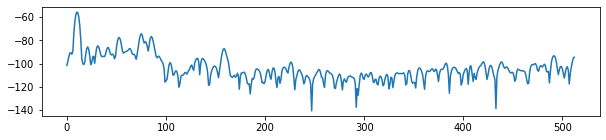

In [75]:
mx1 = mx[5]
plot(mx1)

In [76]:
detect_peaks(mx1,-80)

array([10, 53, 75, 85])

In [77]:
peak_i = np.zeros_like(mx)
for i in range(peak_i.shape[0]):
    idx = detect_peaks(mx[i], t)
    peak_i[i, idx] = 1
    
peak_i[1:634].sum()

11353.0

In [78]:
# for i in range(1, 100):
#     print(peak_i[i].nonzero())
peak_i.shape


(636, 513)

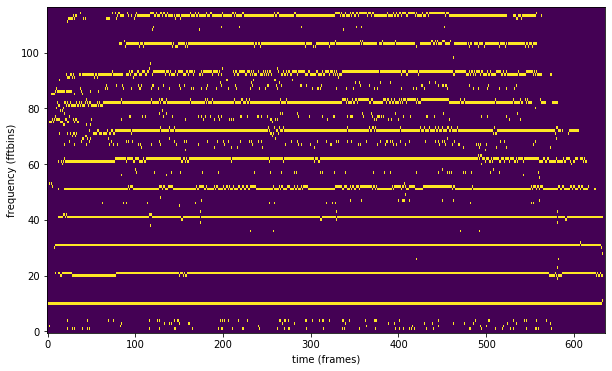

In [79]:
plot_mags(peak_i, max_bin=maxplotbin)

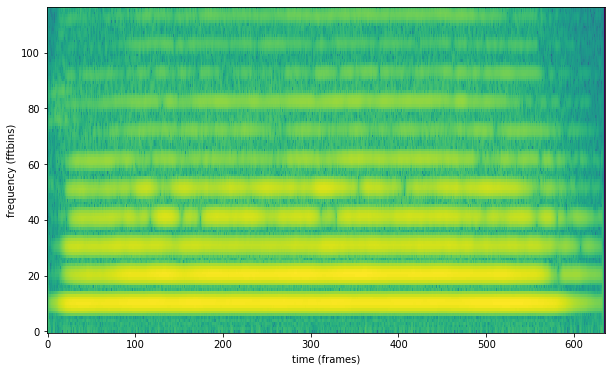

In [80]:
plot_mags(mx, max_bin=maxplotbin)

116

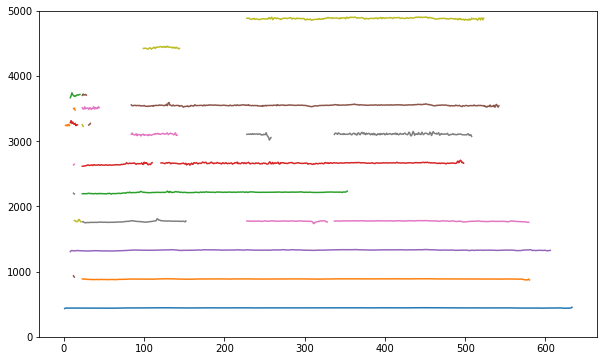

In [81]:
frames = sine_model_analysis(x, sr, w, n_fft, h, t)
min_sine_dur = 0.1
max_n_sines = 150
freq_dev_offset = 10
freq_dev_slope = 0.01

sine_frames = process_frames(frames,
                             max_n_sines=max_n_sines,
                             min_sine_dur=min_sine_dur, 
                             freq_dev_offset=freq_dev_offset,
                             freq_dev_slope=freq_dev_slope)
    
max_frames = max(len(f) for f in sine_frames)
padded = [np.pad(f.freqs, (0, max_frames-f.freqs.size), 'constant') for f in sine_frames]
p = np.stack(padded)
p[p<=0] = np.nan

plt.figure(figsize=(10, 6))
for i in range(9):
    plt.plot(p[:, i])
plt.ylim([0, 5000])
    
maxplotfreq = 5000.0
maxplotbin = int(n_fft*maxplotfreq/sr)
maxplotbin